# Customer Retention by Providing the Right Incentive to the Right People
#### By Aparna Shasty

## Overview

This is a project to demonstrate the following skills:
+ Recognizing/defining the business problem
+ Exploratory Data Analysis (EDA) and Visualizations
+ Data Storytelling
+ Running Hypothesis Tests
+ Drawing inferences
+ Training and Testing Machine Learning models
+ Evaluate Feature Importance
+ Comparing ML Models/improving the performance
+ Recommending measures to retain the customers

### Business Problem

A telecom company has been affected by the increasing number of customers subscribing to the services of a competitor. It is much more expensive to attract new customer than retaining old customer. At the same time, spending too much on or spending on the wrong factor for retaining customer who has no intention to leave (or who was not leaving for that factor which was addressed) could be a waste of  money. Therefore it is important to identify the customer who has high probability of leaving and zero down on the reason for it. An analysis of the past records of the customers can give great insights on who might leave and what is the cause. The telecom company already has this data available and data scientist need not collect the data in this case.

### Step by Step approach to Predicting Customer Churn Rate
#### Quick Examination of the Dataset

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
ch = pd.read_csv('https://community.watsonanalytics.com/wp-content/uploads/2015/03/WA_Fn-UseC_-Telco-Customer-Churn.csv')
ch_orig = ch.copy()
ch.info()
ch.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Note that,

Target (Dependent) Variable: Churn

Feature (Independent) Variables: 19 of them out of 21 shown above. Churn is target, Customer ID is just unique identity.

First question to answer: What percentage of the given dataset has data for customers who switch and what percentage is loyal?

Overall Customer Churn percentage in the given dataset is 26.54 %


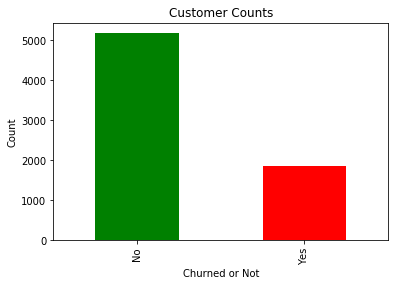

In [3]:
_ = ch.groupby('Churn')['customerID'].count().plot.bar(color='gr')
_ = plt.title('Customer Counts')
_ = plt.ylabel('Count')
_ = plt.xlabel('Churned or Not')
print('Overall Customer Churn percentage in the given dataset is {} %'.format(round(ch.Churn.replace({'No':0,'Yes':1}).mean()*100,2)))

26.54% or 1869 of the records in the dataset belong to Churn customers. This is a binary classification problem with moderately  imbalanced dataset. 

#### Data Wrangling
The output of the cell number 2 above gives all the data types and counts of non-null entries. Non-null does not mean valid entries. We need to ensure all of them have meaningful datatypes and valid entries. The TotalCharges is of type object, which means there is some non-numeric entry. We expect it to be float. I choose to impute the invalid entries with mean of the valid entries, after figuring out how many invalid entries are there.

Senior Citizen is a category variable, however it is given as int. It need not be converted, as it will be eventually converted back to numeric.

In [4]:
print('Number of Total Charges without valid numbers:',ch.TotalCharges[ch.TotalCharges == ' '].count())
mean_total_charges = round(ch.TotalCharges.drop(ch.TotalCharges[ch.TotalCharges == ' '].index).astype(float).mean(),2)
print('Mean Total Charges not including invalid entries',mean_total_charges)
ch.TotalCharges = ch.TotalCharges.apply(lambda x: mean_total_charges  if x == ' ' else float(x))

Number of Total Charges without valid numbers: 11
Mean Total Charges not including invalid entries 2283.3


In [5]:
# Check the stats for numeic types
ch.groupby('Churn').describe().T

Churn                          No          Yes
MonthlyCharges count  5174.000000  1869.000000
               mean     61.265124    74.441332
               std      31.092648    24.666053
               min      18.250000    18.850000
               25%      25.100000    56.150000
               50%      64.425000    79.650000
               75%      88.400000    94.200000
               max     118.750000   118.350000
SeniorCitizen  count  5174.000000  1869.000000
               mean      0.128721     0.254682
               std       0.334923     0.435799
               min       0.000000     0.000000
               25%       0.000000     0.000000
               50%       0.000000     0.000000
               75%       0.000000     1.000000
               max       1.000000     1.000000
TotalCharges   count  5174.000000  1869.000000
               mean   2554.765771  1531.796094
               std    2327.012700  1890.822994
               min      18.800000    18.850000
               25%     579.575000   134.500000
               50%    1689.175000   703.550000
               75%    4262.850000  2331.300000
               max    8672.450000  8684.800000
tenure         count  5174.000000  1869.000000
               mean     37.569965    17.979133
               std      24.113777    19.531123
               min       0.000000     1.000000
               25%      15.000000     2.000000
               50%      38.000000    10.000000
               75%      61.000000    29.000000
               max      72.000000    72.000000

+ Mean tenure for Churn group is lower than the other group, which is as expected.
+ Mean Monthly charges are higher for Churn group, which is OK and could be one factor to address to minimize the Churn.
+ Mean Total Charges are lower for Churn group. It is not clear from the dataset what this means. If this is the cumulative charges from the date of subscription, then it is natural that loyal customers have longer tenure and hence they would end up paying the company more. When the real client is available for discussion, such questions can be clarified with the client.

In [6]:
# Printing how many unique values are present in each column
ch.nunique()

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6530
Churn                  2
dtype: int64

All other variables are fine. Converting object data types to categories and doing one hot encoding are explained along the way. 
#### Exploratory Data Analysis (Numerical and Visual)

Starting the cell below, we plot Churn variable against some key variables, draw insights, hypothesize and conduct some tests when necessary. Observations are documented too.

With bigger datasets, plotting all variables is not possible. The sklearn library functions take care of prioritizing good features (containing info, or those with high variance) over bad ones (containing not much info).

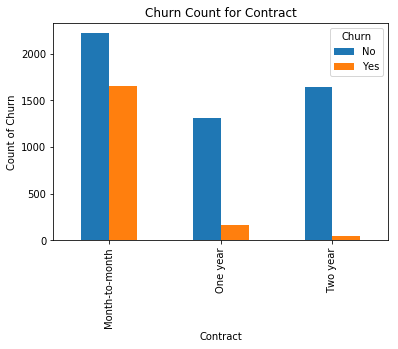

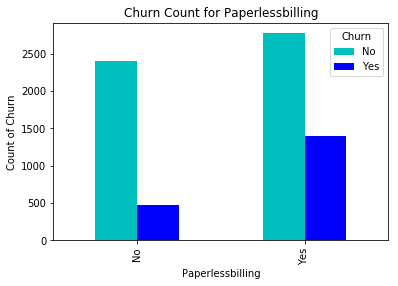

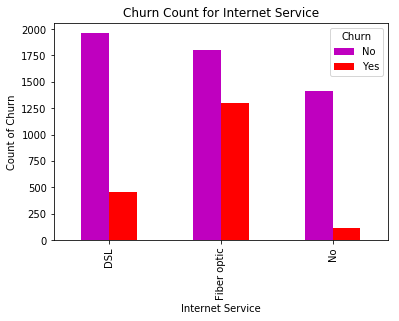

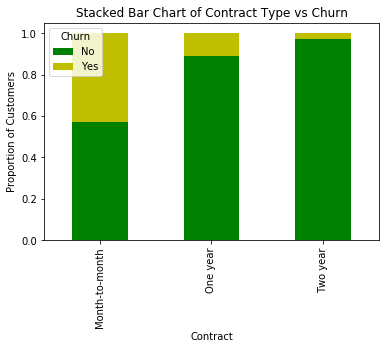

In [7]:
_ = pd.crosstab(ch.Contract,ch.Churn).plot.bar()
_ = plt.title('Churn Count for Contract')
_ = plt.xlabel('Contract')
_ = plt.ylabel('Count of Churn')
_ = pd.crosstab(ch.PaperlessBilling,ch.Churn).plot.bar(color='cb')
_ = plt.title('Churn Count for Paperlessbilling')
_ = plt.xlabel('Paperlessbilling')
_ = plt.ylabel('Count of Churn')
_ = pd.crosstab(ch.InternetService,ch.Churn).plot.bar(color='mr')
_ = plt.title('Churn Count for Internet Service')
_ = plt.xlabel('Internet Service')
_ = plt.ylabel('Count of Churn')
# The Contract plot as stacked bar for learning purposes
table=pd.crosstab(ch.Contract, ch.Churn)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True,color='gy')
_ = plt.title('Stacked Bar Chart of Contract Type vs Churn')
_ = plt.xlabel('Contract')
_ = plt.ylabel('Proportion of Customers')

**Remark**: These plots serve two purposes, instead of a bar plot of mean rates of Churn for two categories in the same variable. They give counts and the relative counts of Churn Vs No churn. Across the categories, they tell us, which category has more members. This is helpful in deciding a few things. Let me explain with an example of Contract.

The month to month contract has high number of people in general and higher proportion of people Churning. The Contract with 2 years has the least members across categories and also within the category, relatively smaller proportion of the people Churn.

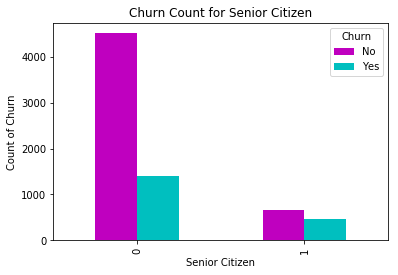

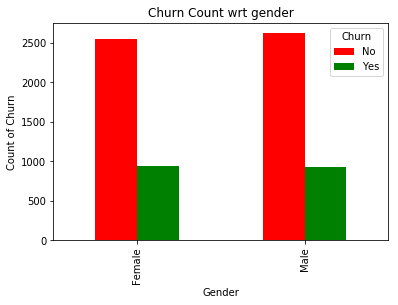

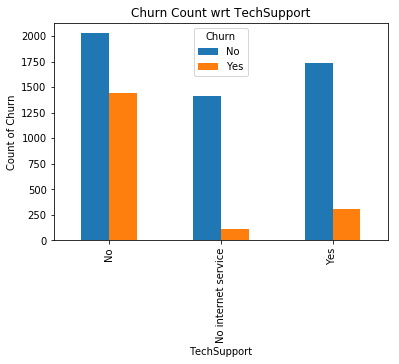

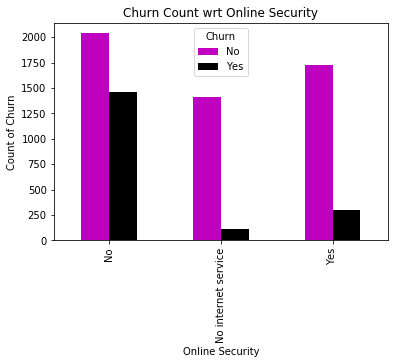

In [8]:
_ = pd.crosstab(ch.SeniorCitizen,ch.Churn).plot.bar(color='mc')
_ = plt.title('Churn Count for Senior Citizen')
_ = plt.xlabel('Senior Citizen')
_ = plt.ylabel('Count of Churn')
_ = plt.figure()
_ = pd.crosstab(ch.gender,ch.Churn).plot.bar(color='rg')
_ = plt.title('Churn Count wrt gender')
_ = plt.xlabel('Gender')
_ = plt.ylabel('Count of Churn')
_ = plt.figure()
_ = pd.crosstab(ch.TechSupport,ch.Churn).plot.bar()
_ = plt.title('Churn Count wrt TechSupport')
_ = plt.xlabel('TechSupport')
_ = plt.ylabel('Count of Churn')
_ = plt.figure()
_ = pd.crosstab(ch.OnlineSecurity,ch.Churn).plot.bar(color='mk')
_ = plt.title('Churn Count wrt Online Security')
_ = plt.xlabel('Online Security')
_ = plt.ylabel('Count of Churn')

**Remark**: We see that heights of all bars except in gender bar chart are varying by great extent.

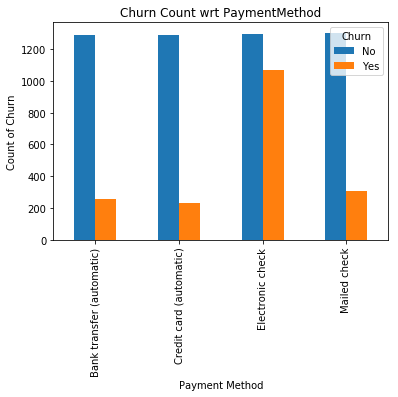

In [9]:
# Let us plot payment method and see
_ = pd.crosstab(ch.PaymentMethod,ch.Churn).plot.bar()
_ = plt.title('Churn Count wrt PaymentMethod')
_ = plt.xlabel('Payment Method')
_ = plt.ylabel('Count of Churn')

**Remark**: We see that although there are 4 categories of payments, the automatic payment categories can be combined into one. There is negligible difference in the churn count and total counts. However, it is best not to combine them into one category, because any new data will have to undergo same procedure. Besides, the new dataset maynot have same properties.

In [10]:
num_var = ['SeniorCitizen','tenure','MonthlyCharges','TotalCharges']
ch1 = ch[num_var]
ch2 = ch.drop(num_var,axis=1)
ch3 = ch2.apply(lambda x: x.astype('category'))
ch  = ch3.apply(lambda x: x.cat.codes)
ch[num_var] = ch1
ch.describe()

,customerID,gender,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,...,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,3521.000000,0.504756,0.483033,0.299588,0.903166,0.940508,0.872923,0.790004,0.906432,0.904444,...,0.985376,0.992475,0.690473,0.592219,1.574329,0.265370,0.162147,32.371149,64.761692,2283.300440
std,2033.283305,0.500013,0.499748,0.458110,0.295752,0.948554,0.737796,0.859848,0.880162,0.879949,...,0.885002,0.885091,0.833755,0.491457,1.068104,0.441561,0.368612,24.559481,30.090047,2265.000258
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.250000,18.800000
25%,1760.500000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,9.000000,35.500000,402.225000
50%,3521.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,29.000000,70.350000,1400.550000
75%,5281.500000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,1.000000,1.000000,2.000000,1.000000,0.000000,55.000000,89.850000,3786.600000
max,7042.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,1.000000,3.000000,1.000000,1.000000,72.000000,118.750000,8684.800000


The above info indicates that 
+ Data is clean, all cells in dataframe are filled. We might need to check for how many unique entries some of them have. We could examine some of them by plotting histogram.

In [11]:
print("Mean Churn Rate for various contract types",ch.groupby('Contract')['Churn'].mean())
print("Mean Churn Rate for Gender:",ch.groupby('gender')['Churn'].mean())
print("Mean Churn Rate for TechSupport:",ch.groupby('TechSupport')['Churn'].mean())
print("Mean Churn Rate for Senior Citizen:",ch.groupby('SeniorCitizen')['Churn'].mean())
print("Mean Churn Rate for Online Security:",ch.groupby('OnlineSecurity')['Churn'].mean())

Mean Churn Rate for various contract types Contract
0    0.427097
1    0.112695
2    0.028319
Name: Churn, dtype: float64
Mean Churn Rate for Gender: gender
0    0.269209
1    0.261603
Name: Churn, dtype: float64
Mean Churn Rate for TechSupport: TechSupport
0    0.416355
1    0.074050
2    0.151663
Name: Churn, dtype: float64
Mean Churn Rate for Senior Citizen: SeniorCitizen
0    0.236062
1    0.416813
Name: Churn, dtype: float64
Mean Churn Rate for Online Security: OnlineSecurity
0    0.417667
1    0.074050
2    0.146112
Name: Churn, dtype: float64


**Remark:** Except gender, other groups have variable mean churn rates. These will be very helpful in modeling.

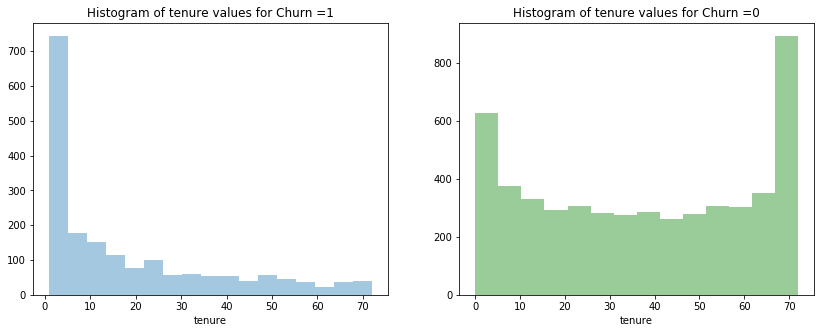

In [12]:
fig, ax = plt.subplots(figsize=(14,5))
_ = plt.subplot(1,2,1)
sns.distplot(ch.loc[ch.Churn==1,'tenure'],hist=True,kde=False)
_ = plt.title('Histogram of tenure values for Churn =1')
_ = plt.subplot(1,2,2)
sns.distplot(ch.loc[ch.Churn==0,'tenure'],hist=True,color='g',kde=False)
_ = plt.title('Histogram of tenure values for Churn =0')

**Remark:** There is a clear distinction in the shape of the two hostograms above. 
+ Customers who cut the contract (churn = 1) are highly concentrated towards lesser tenure (<= 4 years). The number of customers in each higher bin progressively reduces.That is exactly why this is Churn =1 group!
+ The second plot is rather interesting. 
+ The first peak in the second plot tells that there are many more new customers than those in each of the other bins except the last one.
+ Second bin to third bin, there is huge reduction, as some have Churned.
+ Customers who have crossed 20 years are likely to remain loyal and hence the counts are almost same until bin centered 60.
+ The last peak is a fact about the current dataset. It seems like there are many old customers (> 850) who have stayed with the connection for more than 60 years. Does this mean that 60 years ago, customer churn started and there was a sudden drop from which the company is trying to recover?

Mean Tenure of Two groups
 Churn
0    37.569965
1    17.979133
Name: tenure, dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


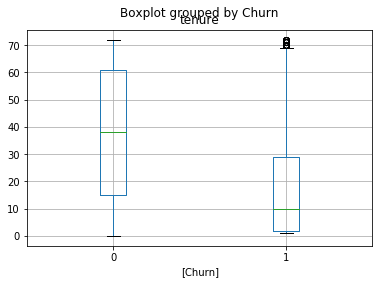

In [13]:
print("Mean Tenure of Two groups\n",ch.groupby('Churn').tenure.mean())
_ = plt.figure()
_ = ch[['Churn','tenure']].boxplot(by='Churn')

The huge difference in the mean tenure makes us suspect that there is a clear separability. Boxplot gives a clearer visibility on the difference. We could run a 2 sample hypothesis test to verify this.

H0: mu1 = mu0

HA: mu1 != mu0

alpha = 0.01

In [14]:
sigma12 = np.sqrt((ch[ch.Churn==1].tenure.var()/ch[ch.Churn==1].tenure.count()) + (ch[ch.Churn==0].tenure.var()/ch[ch.Churn==0].tenure.count()))
zsc12 = abs(ch[ch.Churn==1].tenure.mean() - ch[ch.Churn==0].tenure.mean())/sigma12
print("Zscore for the two sample test = ",zsc12)

Zscore for the two sample test =  34.8238186963


The high Z score indicates that that p-value is negligibly small (almost 0), hence H0 is rejected in favor of HA

Mean Total Charge paid by Two groups
 Churn
0    2554.765771
1    1531.796094
Name: TotalCharges, dtype: float64


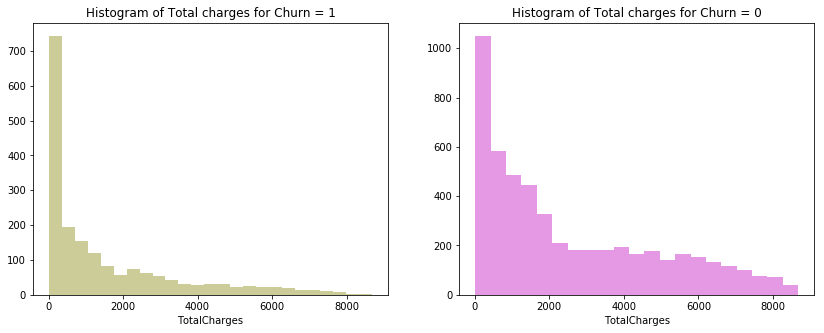

In [15]:
fig, ax = plt.subplots(figsize=(14,5))
_ = plt.subplot(1,2,1)
_ = sns.distplot(ch.loc[ch.Churn==1,'TotalCharges'],hist=True,kde=False,color='olive')
_ = plt.title('Histogram of Total charges for Churn = 1')
_ = plt.subplot(1,2,2)
_ = sns.distplot(ch.loc[ch.Churn==0,'TotalCharges'],hist=True,kde=False,color='m')
_ = plt.title('Histogram of Total charges for Churn = 0')
print("Mean Total Charge paid by Two groups\n",ch.groupby('Churn').TotalCharges.mean())

This histogram is a bit different and needs more inputs to understand.

Mean Monthly Charge paid by Two groups
 Churn
0    61.265124
1    74.441332
Name: MonthlyCharges, dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


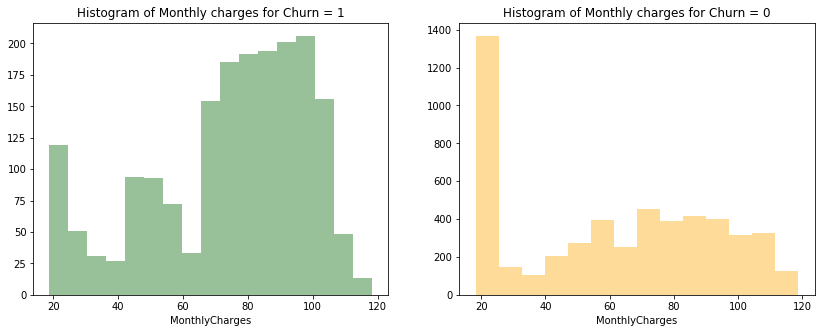

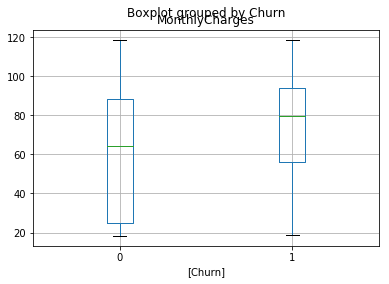

In [16]:
fig, ax = plt.subplots(figsize=(14,5))
_ = plt.subplot(1,2,1)
_ = sns.distplot(ch.loc[ch.Churn==1,'MonthlyCharges'],hist=True,kde=False,color='darkgreen')
_ = plt.title('Histogram of Monthly charges for Churn = 1')
_ = plt.subplot(1,2,2)
_ = sns.distplot(ch.loc[ch.Churn==0,'MonthlyCharges'],hist=True,kde=False,color='orange')
_ = plt.title('Histogram of Monthly charges for Churn = 0')
print("Mean Monthly Charge paid by Two groups\n",ch.groupby('Churn').MonthlyCharges.mean())
_ = ch[['Churn','MonthlyCharges']].boxplot(by='Churn')

**Remarks:** Clearly there is a significant number of customers in the Churn group whose monthly charges are towards higher end(70 to 120). On the other hand, the non churn group has close to 1400 customers in bin value 20. We must recognize that the monthly charges being may not be the cause, but could be effect. In the Churn group, majority are those who leave within a few years. Hence their charges might be high. The telecom company might be charging old customers lesser charges because when they started decades ago, charges were lower and it was not increased to retain them or as a token of appreciating the loyalty. It does not matter for machine learning algorithms, as long as there is correlation.

The box plot gives a better clue on the spread. We can run a two sample hypothesis test to understand this better.

In [17]:
sigma12 = np.sqrt((ch[ch.Churn==1].MonthlyCharges.var()/ch[ch.Churn==1].MonthlyCharges.count()) + (ch[ch.Churn==0].MonthlyCharges.var()/ch[ch.Churn==0].MonthlyCharges.count()))
zsc12 = abs(ch[ch.Churn==1].MonthlyCharges.mean() - ch[ch.Churn==0].MonthlyCharges.mean())/sigma12
print("Zscore for the two sample test for monthly charges= ",zsc12)

Zscore for the two sample test for monthly charges=  18.4075266764


The high Z score indicates good separation between the two groups.

Before we could move to predictive modeling, we should examine correlations between at least some of the features, which intuitively seem to have some relation.
#### EValuating Correlations

Pearson Correlation between Total Charges and Tenure: (0.82475731603583202, 0.0)


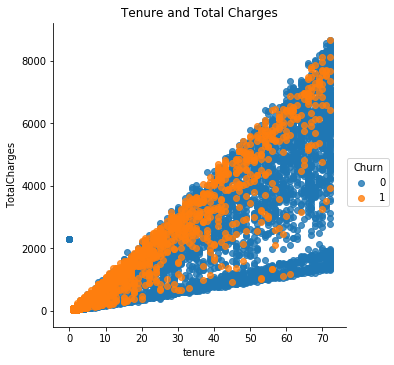

In [20]:
from  scipy.stats import pearsonr
# We will plot two variables together and see how it looks
_ = plt.figure(figsize=(16,6))
_ = sns.lmplot(x='tenure',y='TotalCharges', data=ch,
           fit_reg=False, # No regression line
           hue='Churn')
_ = plt.title('Tenure and Total Charges')
print("Pearson Correlation between Total Charges and Tenure:",pearsonr(ch.tenure,ch.TotalCharges))

**Remark**: There is high correlation between TotalCharges and Tenure. How about Monthly Charges and Tenure?

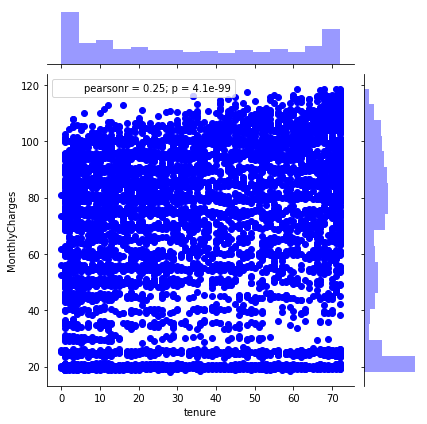

In [21]:
_ = plt.figure(figsize=(16,6))
_ = sns.jointplot(x='tenure',y='MonthlyCharges', data=ch,color='b')

The correlation between tenure and monthly charges is weak. This is good for modeling purposes. The points are well dispersed. There are some regions which are more dense than the others. This is what is showing up as correlation of 0.25

In [22]:
print("Multiple Lines category counts:\n",ch.MultipleLines.value_counts())
print("Phone Lines category counts:\n",ch.PhoneService.value_counts())

Multiple Lines category counts:
 0    3390
2    2971
1     682
Name: MultipleLines, dtype: int64
Phone Lines category counts:
 1    6361
0     682
Name: PhoneService, dtype: int64


From the above, Phone service is a subset of multiple lines. It does not contain any new information.

In [23]:
y = ch.Churn
X = ch.drop(['customerID','Churn','PhoneService'],axis=1,inplace=False) 

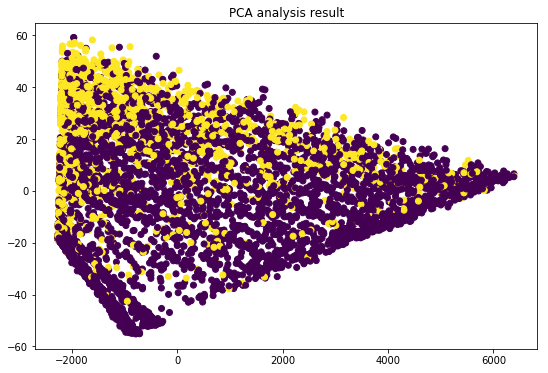

In [24]:
# We will reduce all features to 2D by PCA.
from sklearn.decomposition import PCA
pca = PCA()
_ = plt.figure(figsize=(9,6))
xx = pca.fit_transform(X)
xs = xx[:,0]
ys = xx[:,1]
_ = plt.scatter(xs,ys,c=y)
_ = plt.title('PCA analysis result')

**Remark**: The PCA indicates how much the projection of X in 2D is separable. The real separability will be better than this, as it is in more dimensions. 

In [25]:
X.nunique()

gender                 2
Partner                2
Dependents             2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
SeniorCitizen          2
tenure                73
MonthlyCharges      1585
TotalCharges        6530
dtype: int64

#### Preparing the data for Predictive Analysis, by One hot encoding
Creating one hot encoding to suit logistic regression is important for the correct interpretation of the features by the model. We do that below, and then drop original columns and the last column of each variable, as it is correlated to the others.

In [26]:
cat_vars=['MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','Contract','PaymentMethod']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(ch[var], prefix=var)
    X1=X.join(cat_list)
    X=X1
X.drop(cat_vars,axis=1,inplace=True)
X.drop(['MultipleLines_2','InternetService_2','OnlineSecurity_2','OnlineBackup_2','DeviceProtection_2',
       'TechSupport_2','StreamingTV_2','StreamingMovies_2','Contract_2','PaymentMethod_3'],axis=1,inplace=True)
X.columns

Index(['gender', 'Partner', 'Dependents', 'PaperlessBilling', 'SeniorCitizen',
       'tenure', 'MonthlyCharges', 'TotalCharges', 'MultipleLines_0',
       'MultipleLines_1', 'InternetService_0', 'InternetService_1',
       'OnlineSecurity_0', 'OnlineSecurity_1', 'OnlineBackup_0',
       'OnlineBackup_1', 'DeviceProtection_0', 'DeviceProtection_1',
       'TechSupport_0', 'TechSupport_1', 'StreamingTV_0', 'StreamingTV_1',
       'StreamingMovies_0', 'StreamingMovies_1', 'Contract_0', 'Contract_1',
       'PaymentMethod_0', 'PaymentMethod_1', 'PaymentMethod_2'],
      dtype='object')

#### Fitting Predictive Models.
 
The goals of Predictive Model fitting are,
+ To identify the customers with high probability of switching to competition (Ranking)
+ To identify the causes behind the tendency to leave (feature importance)
+ To make predictions and assess the capacity of the model for future data (Predictive power)
+ Use all the results and make recommendations to the telecom company.

#### Metrics to assess the model:
We are interested in customers who have tendency to go away (i.e. label 1). We may not mind a few false alarms especially if the measures taken to retain them is relatively inexpensive compared to the loss due to missing the true alarms. The measures taken on the customers who had no intention to leave can result in improved customer satisfaction and hence long term benefits.

We want high recall on class 1. 

In [27]:
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [28]:
scaler = StandardScaler()
X_new = scaler.fit_transform(X)
Xtrain, Xdev, ytrain,ydev = train_test_split(X_new,y,test_size=0.4,random_state=42,stratify=y)
#Xdev, Xtest, ydev,ytest = train_test_split(Xt,yt,test_size=0.5,random_state=42,stratify=yt)

Confusion Matrix:
 [[1853  217]
 [ 328  420]]
Report:
              precision    recall  f1-score   support

          0       0.85      0.90      0.87      2070
          1       0.66      0.56      0.61       748

avg / total       0.80      0.81      0.80      2818

Dev Set Accuracy 0.806600425834
Train set Accuracy 0.80449704142


Text(0.5,0,'False Positive Rate')

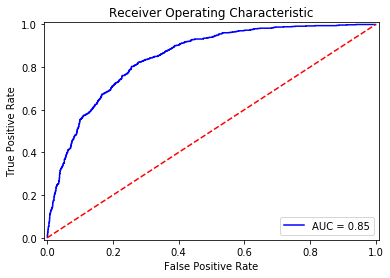

In [29]:
logreg = LogisticRegression()
logreg.fit(Xtrain,ytrain)
yp_dev = logreg.predict(Xdev)
print("Confusion Matrix:\n",confusion_matrix(ydev,yp_dev))
print("Report:\n",classification_report(ydev,yp_dev))
print("Dev Set Accuracy",accuracy_score(ydev,yp_dev))
print("Train set Accuracy",accuracy_score(ytrain,logreg.predict(Xtrain)))
yprob = logreg.predict_proba(Xdev)
false_positive_rate, true_positive_rate, thresholds = roc_curve(ydev, yprob[:,1],pos_label=1)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.01,1.01])
plt.ylim([-0.01,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [30]:
print("Report with threshold 0.2:\n",classification_report(ydev,(yprob[:,1]>=0.2)))
print("Dev Set Accuracy with thresh 0.2",accuracy_score(ydev,(yprob[:,1]>=0.2)))

Report with threshold 0.2:
              precision    recall  f1-score   support

          0       0.93      0.64      0.76      2070
          1       0.46      0.88      0.61       748

avg / total       0.81      0.70      0.72      2818

Dev Set Accuracy with thresh 0.2 0.69907735983


In [31]:
# Coefficients with LogReg
coeffs = logreg.coef_[0,np.argsort((logreg.coef_[0,:]))]
names = list(X.columns[np.argsort(logreg.coef_[0,:])])
print("Coefficients and Indices in increasing magnitude")
pd.DataFrame(coeffs,index=names)

Coefficients and Indices in increasing magnitude


,0
tenure,-1.234462
MonthlyCharges,-0.560369
InternetService_0,-0.242137
StreamingMovies_0,-0.200283
MultipleLines_0,-0.181791
StreamingTV_0,-0.163668
TechSupport_1,-0.131339
OnlineBackup_1,-0.131339
OnlineSecurity_1,-0.131339
StreamingMovies_1,-0.131339


In [32]:
# Feature importance
coeffs1 = logreg.coef_[0,np.argsort(abs(logreg.coef_[0,:]))[::-1]]
names1 = list(X.columns[np.argsort(abs(logreg.coef_[0,:]))[::-1]])
print("6 Most important features")
pd.DataFrame(coeffs1,index=names1).head(6)

6 Most important features


,0
tenure,-1.234462
Contract_0,0.679986
MonthlyCharges,-0.560369
TotalCharges,0.554989
InternetService_1,0.340723
Contract_1,0.266839


Confusion Matrix:
 [[1882  188]
 [ 383  365]]
Report:
              precision    recall  f1-score   support

          0       0.83      0.91      0.87      2070
          1       0.66      0.49      0.56       748

avg / total       0.79      0.80      0.79      2818

Dev Set Accuracy 0.797374024131
Train set Accuracy 0.887337278107


Text(0.5,0,'False Positive Rate')

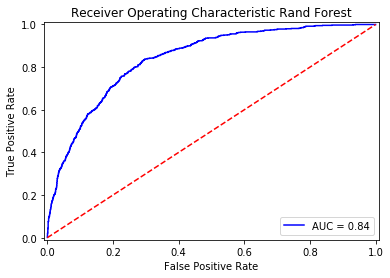

In [33]:
rand_forest = RandomForestClassifier(250,'entropy',13,min_samples_leaf=3)
rand_forest.fit(Xtrain,ytrain)
yp_dev = rand_forest.predict(Xdev)
print("Confusion Matrix:\n",confusion_matrix(ydev,yp_dev))
print("Report:\n",classification_report(ydev,yp_dev))
print("Dev Set Accuracy",accuracy_score(ydev,yp_dev))
print("Train set Accuracy",accuracy_score(ytrain,rand_forest.predict(Xtrain)))
yprob = rand_forest.predict_proba(Xdev)
false_positive_rate, true_positive_rate, thresholds = roc_curve(ydev, yprob[:,1],pos_label=1)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.title('Receiver Operating Characteristic Rand Forest')
plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.01,1.01])
plt.ylim([-0.01,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

In [34]:
print("Report with threshold 0.2:\n",classification_report(ydev,(yprob[:,1]>=0.2)))
print("Dev Set Accuracy with thresh 0.2",accuracy_score(ydev,(yprob[:,1]>=0.2)))

Report with threshold 0.2:
              precision    recall  f1-score   support

          0       0.93      0.65      0.76      2070
          1       0.47      0.86      0.61       748

avg / total       0.81      0.70      0.72      2818

Dev Set Accuracy with thresh 0.2 0.703690560681


The Recall value of 0.86 is good. Both Random Forest and Logistic Regression are giving similar results.

In [35]:
fi = rand_forest.feature_importances_ 
print("6 Most important features are")
pd.DataFrame(np.argsort(fi)[::-1][:6],index = list(X.columns[np.argsort(fi)[::-1]])[:6])

6 Most important features are


,0
tenure,5
TotalCharges,7
MonthlyCharges,6
Contract_0,24
OnlineSecurity_0,12
TechSupport_0,18


There are 4 features common in the top 6, between Logistic Regression and Random Forest. They are tenure, Total Charges, Monthly Charges and Contract. Tech Support, Online Security and Internet Service are the remaining 3 in the union of these two. Total Charges is correlated with Tenure, it is the result of payments over years perhaps. Hence it is really not an action item. 

To know the action items, we will be doing some clustering and further analysis. Before we move on to that, here is an account of some more predictive models tried and their AUC score.

Test accuracy 0.791341376863
Train accuracy 0.817278106509
Confusion Matrix:
 [[1839  231]
 [ 357  391]]
Report:
              precision    recall  f1-score   support

          0       0.84      0.89      0.86      2070
          1       0.63      0.52      0.57       748

avg / total       0.78      0.79      0.78      2818



Text(0.5,0,'False Positive Rate')

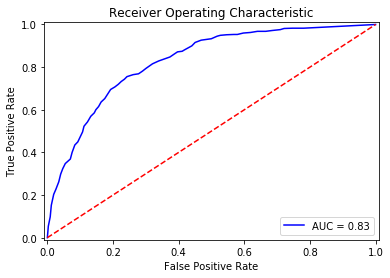

In [36]:
dt = DecisionTreeClassifier(min_weight_fraction_leaf=0.01)
dt.fit(Xtrain,ytrain)
yp_dev = dt.predict(Xdev)
print("Test accuracy",accuracy_score(ydev,yp_dev))
print("Train accuracy",accuracy_score(ytrain,dt.predict(Xtrain)))
print("Confusion Matrix:\n",confusion_matrix(ydev,yp_dev))
print("Report:\n",classification_report(ydev,yp_dev))
yprob = dt.predict_proba(Xdev)
false_positive_rate, true_positive_rate, thresholds = roc_curve(ydev, yprob[:,1],pos_label=1)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.01,1.01])
plt.ylim([-0.01,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

Train accuracy 0.800473372781
Test accuracy 0.787437899219
             precision    recall  f1-score   support

          0       0.82      0.91      0.86      2070
          1       0.65      0.44      0.52       748

avg / total       0.77      0.79      0.77      2818



Text(0.5,0,'False Positive Rate')

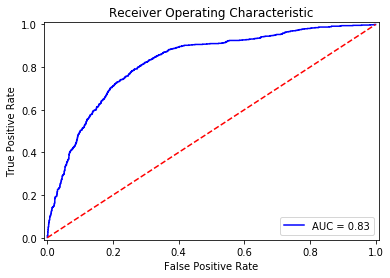

In [37]:
svc_model = SVC(C=0.1,kernel='rbf',gamma=0.02,random_state=21)
svc_model.fit(Xtrain,ytrain)
print("Train accuracy",svc_model.score(Xtrain,ytrain))
print("Test accuracy",svc_model.score(Xdev,ydev))
print(classification_report(ydev,svc_model.predict(Xdev)))
yscore = svc_model.decision_function(Xdev)
false_positive_rate, true_positive_rate, thresholds = roc_curve(ydev, yscore,pos_label=1)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.01,1.01])
plt.ylim([-0.01,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

[False False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True False False  True]
[4 5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 2 1]
Index(['Dependents', 'PaperlessBilling', 'SeniorCitizen', 'tenure',
       'MonthlyCharges', 'TotalCharges', 'MultipleLines_0', 'MultipleLines_1',
       'InternetService_0', 'InternetService_1', 'OnlineSecurity_0',
       'OnlineSecurity_1', 'OnlineBackup_0', 'OnlineBackup_1',
       'DeviceProtection_0', 'DeviceProtection_1', 'TechSupport_0',
       'TechSupport_1', 'StreamingTV_0', 'StreamingTV_1', 'StreamingMovies_0',
       'StreamingMovies_1', 'Contract_0', 'Contract_1', 'PaymentMethod_2'],
      dtype='object')
Confusion Matrix:
 [[1850  220]
 [ 328  420]]
Report:
              precision    recall  f1-score   support

          0       0.85      0.89      0.87      2070
          1       0.66      0.56      0.61       748

avg / total       0.80

Text(0.5,0,'False Positive Rate')

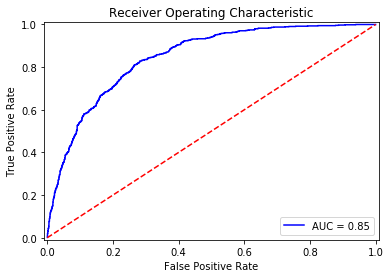

In [38]:
# Trying Feature Selection
from sklearn.feature_selection import RFE
model = LogisticRegression()
rfe = RFE(model, 25)
rfe = rfe.fit(Xtrain, ytrain)
print(rfe.support_)
print(rfe.ranking_)
Xp = X.loc[:,X.columns[rfe.support_]]
print(X.columns[rfe.support_])
X_new1 = scaler.fit_transform(Xp)
Xtrain1, Xt, ytrain1,yt = train_test_split(X_new1,y,test_size=0.4,random_state=42,stratify=y)
logreg = LogisticRegression()
logreg.fit(Xtrain1,ytrain1)
yp = logreg.predict(Xt)
print("Confusion Matrix:\n",confusion_matrix(yt,yp))
print("Report:\n",classification_report(yt,yp))
print("Dev Set Accuracy",accuracy_score(yt,yp))
print("Train set Accuracy",accuracy_score(ytrain1,logreg.predict(Xtrain1)))
yprob = logreg.predict_proba(Xt)
false_positive_rate, true_positive_rate, thresholds = roc_curve(yt, yprob[:,1],pos_label=1)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.01,1.01])
plt.ylim([-0.01,1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

Reference on how to plot AUC is [here](https://datamize.wordpress.com/2015/01/24/how-to-plot-a-roc-curve-in-scikit-learn/)

### Clustering

We will use K-Means clustering to do some analysis to come up with recommendations.
Churn population and non-Churn population are separately clustered into 3 and compared.


Cluster Centers for  Churn are at:
[ 47.45558087  93.86503417] 438
[  8.82172996  83.58238397] 949
[  9.14315353  38.77178423] 482
Cluster Centers for no Churn are at:
[ 32.54916201  24.75938547] 1790
[ 59.20247046  89.49406552] 1862
[ 17.00985545  69.66392904] 1522


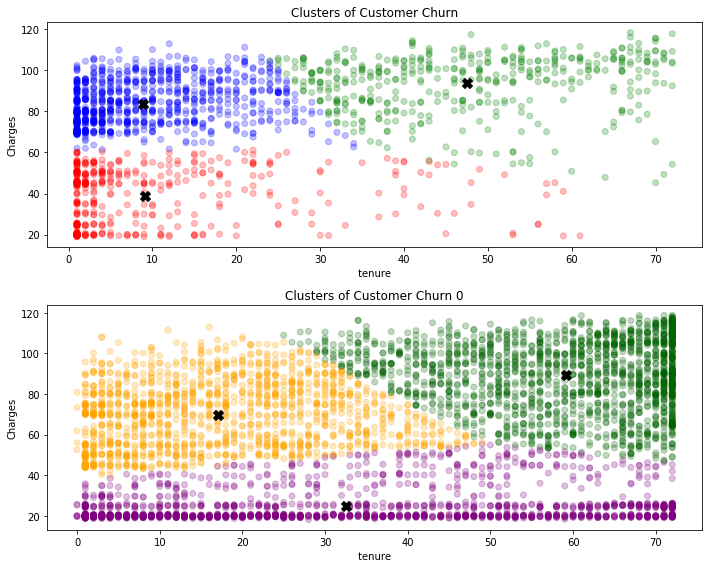

In [39]:
# Import KMeans Model
from sklearn.cluster import KMeans

# Graph and create 3 clusters of Customer Churn
kmeans = KMeans(n_clusters=3,random_state=2)
kmeans.fit(ch[ch.Churn==1][["tenure","MonthlyCharges"]])

kmeans_colors = ['green' if c == 0 else 'blue' if c == 2 else 'red' for c in kmeans.labels_]
fig, ax = plt.subplots(figsize=(10, 8))
plt.subplot(2,1,1) #figsize=(10, 6))
plt.scatter(x="tenure",y="MonthlyCharges", data=ch[ch.Churn==1],
            alpha=0.25,color = kmeans_colors)
plt.xlabel(" tenure ")
plt.ylabel("Charges")
plt.scatter(x=kmeans.cluster_centers_[:,0],y=kmeans.cluster_centers_[:,1],color="black",marker="X",s=100)
plt.title("Clusters of Customer Churn")
print("Cluster Centers for  Churn are at:")
print(kmeans.cluster_centers_[0,:],(kmeans.labels_==0).sum())
print(kmeans.cluster_centers_[2,:],(kmeans.labels_==2).sum())
print(kmeans.cluster_centers_[1,:],(kmeans.labels_==1).sum())

plt.subplot(2,1,2)

# Graph and create 3 clusters of Customer Churn
kmeans = KMeans(n_clusters=3,random_state=2)
kmeans.fit(ch[ch.Churn==0][["tenure","MonthlyCharges"]])

kmeans_colors = ['darkgreen' if c == 0 else 'orange' if c == 2 else 'purple' for c in kmeans.labels_]

plt.scatter(x="tenure",y="MonthlyCharges", data=ch[ch.Churn==0],
            alpha=0.25,color = kmeans_colors)
plt.xlabel(" tenure ")
plt.ylabel("Charges")
plt.scatter(x=kmeans.cluster_centers_[:,0],y=kmeans.cluster_centers_[:,1],color="black",marker="X",s=100)
plt.title("Clusters of Customer Churn 0")
print("Cluster Centers for no Churn are at:")
print(kmeans.cluster_centers_[1,:],(kmeans.labels_==1).sum())
print(kmeans.cluster_centers_[0,:],(kmeans.labels_==0).sum())
print(kmeans.cluster_centers_[2,:],(kmeans.labels_==2).sum())
_ = plt.tight_layout()

**Remarks**:
+ In the Churn group, There are relatively less customers in the lower right corner of the plot. Hence, trying to evaluate what incentives might make this group change their decision will not be of much benefit to the business.
+ It is apparent that there is a bunch of customers who pay less than 60 bucks per month and yet stop the subscribing. These people's reason may not have to do with Charges, but something else.
+ The blue cluster members, at least some of them, perhaps those who do not stay beyond 20 years are likely to change their mind if the monthly charges are lowered.
+ The green cluster members might have some other reasons for changing despite being subscribers for 25+ years with the company. It is better to dig more data by conducting short surveys on some people and if the response pointed at monthly charges as the cause for majority of them, then reducing the monthly charges will help.
+ A comment on reducing charges: This will benefit in the long run because of volumes although temporarily it will result in loss of revenue.